In [6]:
#Importing necessary packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [2]:
## Importing training data with mapped variables from other datasets provided
application_train_mapped = pd.read_csv('./Stored files/application_train_mapped_4.csv')

In [162]:
application_train_mapped.shape

(307511, 214)

In [4]:
# For the mapped variables replace inf values and certain values which are as good as NaNs

application_train_mapped.replace([np.inf,-np.inf],np.nan,inplace= True)
application_train_mapped.replace(['XNA',''],np.nan,inplace= True)

In [5]:
application_train_mapped.info(null_counts=True, verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 214 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   SK_ID_CURR                         307511 non-null  int64  
 1   TARGET                             307511 non-null  int64  
 2   NAME_CONTRACT_TYPE                 307511 non-null  object 
 3   CODE_GENDER                        307507 non-null  object 
 4   FLAG_OWN_CAR                       307511 non-null  object 
 5   FLAG_OWN_REALTY                    307511 non-null  object 
 6   CNT_CHILDREN                       307511 non-null  int64  
 7   AMT_INCOME_TOTAL                   307511 non-null  float64
 8   AMT_CREDIT                         307511 non-null  float64
 9   AMT_ANNUITY                        307499 non-null  float64
 10  AMT_GOODS_PRICE                    307233 non-null  float64
 11  NAME_TYPE_SUITE                    306

In [163]:
print("Numeric variables: ", len(application_train_mapped.select_dtypes(exclude = 'object').columns))
print("Categorical variables: ", len(application_train_mapped.select_dtypes(include = 'object').columns))

Numeric variables:  194
Categorical variables:  20


**We can see below that event rate i.e. customer going bad or unable to pay the loan is 8.07%**

In [174]:
application_train_mapped.TARGET.value_counts(normalize=True,dropna=False) * 100

0    91.927118
1     8.072882
Name: TARGET, dtype: float64

### Exploring the distribution of numeric features

In [7]:
describe = np.round(application_train_mapped.describe(exclude = 'object',percentiles = [.25,.50,.75,.90,.95]),1)
describe.loc['missing'] = np.round(application_train_mapped.isna().sum()/len(application_train_mapped)*100,1)
describe.iloc[:,2:]

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,total_unique_trades,active_loans_curr,active_loans_6m_prior,active_loans_12m_prior,active_loans_24m_prior,active_loans_36m_prior,active_loans_48m_prior,completed_loans_curr,completed_loans_6m_prior,completed_loans_12m_prior,completed_loans_24m_prior,completed_loans_36m_prior,completed_loans_48m_prior,delq_trades_curr,delq_trades_6m_prior,delq_trades_12m_prior,delq_trades_24m_prior,delq_trades_36m_prior,delq_trades_48m_prior,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,prop_pending_installment,total_unique_cc_trades,active_cc_trades_curr,active_cc_trades_6m_prior,active_cc_trades_12m_prior,active_cc_trades_24m_prior,active_cc_trades_36m_prior,active_cc_trades_48m_prior,completed_cc_trades_curr,completed_cc_trades_6m_prior,completed_cc_trades_12m_prior,completed_cc_trades_24m_prior,completed_cc_trades_36m_prior,completed_cc_trades_48m_prior,delq_cc_loans_curr,delq_cc_loans_6m_prior,delq_cc_loans_12m_prior,delq_cc_loans_24m_prior,delq_cc_loans_36m_prior,delq_cc_loans_48m_prior,min_due_unpaid_prior_6m,min_due_unpaid_prior_12m,min_due_unpaid_prior_24m,min_due_unpaid_prior_36m,min_due_unpaid_prior_48m,util_prior_6m_mean,util_prior_6m_max,util_prior_6m_min,util_prior_12m_mean,util_prior_12m_max,util_prior_12m_min,util_prior_24m_mean,util_prior_24m_max,util_prior_24m_min,util_prior_36m_mean,util_prior_36m_max,util_prior_36m_min,util_prior_48m_mean,util_prior_48m_max,util_prior_48m_min,prev_app_approved_count,prev_app_canceled_count,prev_app_Refused_count,prev_app_avg_ticket_size,prev_app_avg_LTV,prev_app_avg_EMI,prev_app_avg_down_pmt_rate,prev_app_avg_tenor,prev_app_cash_loans_approved,prev_app_consumer_loans_approved,prev_app_revolving_loans_approved,avg_gap,times_late_pmt_past_6m,times_late_pmt_past_12m,times_late_pmt_past_24m,times_late_pmt_past_36m,times_late_pmt_past_48m,times_partial_pmt_6m,times_partial_pmt_12m,times_partial_pmt_24m,times_partial_pmt_36m,times_partial_pmt_48m,times_pre_pmt_6m,times_pre_pmt_12m,times_pre_pmt_24m,times_pre_pmt_36m,times_pre_pmt_48m
count,307511.0,307511.0,307511.0,307499.0,307233.0,307511.0,307511.0,307511.0,307511.0,307511.0,104582.0,307511

In [165]:
describe.loc[:,describe.loc['missing'] > 50]

,OWN_CAR_AGE,EXT_SOURCE_1,APARTMENTS_AVG,BASEMENTAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMIN_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMIN_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,util_prior_6m_mean,util_prior_6m_max,util_prior_6m_min,util_prior_12m_mean,util_prior_12m_max,util_prior_12m_min,util_prior_24m_mean,util_prior_24m_max,util_prior_36m_mean,util_prior_36m_max,util_prior_36m_min,util_prior_48m_mean,util_prior_48m_max,util_prior_48m_min
count,104582.0,134133.0,151450.0,127568.0,143620.0,152683.0,98869.0,153161.0,137829.0,151450.0,127568.0,143620.0,152683.0,153161.0,137829.0,151450.0,127568.0,143620.0,152683.0,98869.0,153161.0,137829.0,67903.0,67903.0,67959.0,71183.0,71183.0,71321.0,78472.0,78472.0,78494.0,78494.0,78909.0,78498.0,78498.0,78928.0
mean,12.1,0.5,0.1,0.1,0.1,0.1,0.2,0.1,0.0,0.1,0.1,0.1,0.1,0.1,0.0,0.1,0.1,0.1,0.1,0.2,0.1,0.0,32.4,41.0,23.1,29.9,44.0,13.4,27.7,45.2,28.7,49.6,6.4,30.0,53.8,5.9
std,11.9,0.2,0.1,0.1,0.1,0.1,0.2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.2,0.1,0.1,40.4,47.0,36.2,37.1,47.9,28.2,34.8,48.4,34.3,48.6,19.4,34.0,48.5,18.6
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.5,0.0,-180.0
25%,5.0,0.3,0.1,0.0,0.0,0.1,0.1,0.0,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,9.0,0.5,0.1,0.1,0.0,0.1,0.2,0.1,0.0,0.1,0.1,0.0,0.1,0.1,0.0,0.1,0.1,0.0,0.1,0.2,0.1,0.0,0.0,0.1,0.0,1.8,8.2,0.0,2.4,13.3,8.5,41.4,0.0,14.0,64.1,0.0
75%,15.0,0.7,0.1,0.1,0.1,0.2,0.4,0.1,0.0,0.1,0.1,0.1,0.2,0.1,0.0,0.1,0.1,0.1,0.2,0.4,0.1,0.0,74.9,97.9,44.7,64.2,100.5,1.3,57.6,101.4,58.2,102.4,0.0,59.2,103.1,0.0
max,91.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,448.8,1177.8,244.3,270.9,1177.8,244.3,244.3,1177.8,244.3,1177.8,244.3,244.3,1177.8,244.3
missing,66.0,56.4,50.7,58.5,53.3,50.3,67.8,50.2,55.2,50.7,58.5,53.3,50.3,50.2,55.2,50.7,58.5,53.3,50.3,67.8,50.2,55.2,77.9,77.9,77.9,76.9,76.9,76.8,74.5,74.5,74.5,74.5,74.3,74.5,74.5,74.3


### Bivariate analysis (Eliminating variables basis information value)

As we can see from above table there are **36 columns** where more than **50% data is missing**. Instead of trying to impute values into all these columns we will do a bivariate analysis to eliminate certain unimportant variables. In bivariate analysis we check for relationship between the Features and Target using a metric called Information value. Information value is the measure of the predictive power of a given feature.
The functions below are used to run bivariate analysis on numeric and categorical variables which return two dataframes, one with WOE for each variable and other with the information value of each variable.

We will drop those features whose **IV < 0.02** as these have very low predictive power


In [10]:
def biv_numeric(dataframe_input, good_bad_dataframe, var, n_bins=10):
    dataframe_out = pd.DataFrame()
    for col in var:

        df = pd.concat([dataframe_input[col], good_bad_dataframe],axis = 1)
        df['bins'] = pd.qcut(dataframe_input[col].apply(float), n_bins, duplicates='drop')
        #df.loc[dataframe_input[col].isna(),'bins'] = 'Missing'
        df['bins'] = df['bins'].cat.add_categories('Missing')
        df.bins.fillna('Missing', inplace = True)
        
        a = df.groupby(df.bins,as_index=False)[df.columns[1]].count().rename(columns = {df.columns[1]:'Total'})
        b = df.groupby(df.bins,as_index=False)[df.columns[1]].sum().rename(columns = {df.columns[1]:'n_bads'})
        df = a.merge(b,on='bins')
        
        df['n_goods'] = df['Total']-df['n_bads']
        df['Pop_perc'] = df['Total']/df['Total'].sum()
        df['bad_rate'] = df['n_bads']/df['Total']
        df['good_dist'] = df['n_goods']/df['n_goods'].sum()
        df['bad_dist'] = df['n_bads']/df['n_bads'].sum()
        df['WOE'] = np.ma.masked_invalid(np.log(df['good_dist']/df['bad_dist']))
        df['IV'] = ((df['good_dist'] - df['bad_dist'])*np.ma.masked_invalid(df['WOE'])).sum()
        df.insert(loc = 0, column='varname', value = col)

        dataframe_out = pd.concat([dataframe_out, df], ignore_index = True)
        dataframe_out = dataframe_out.append(pd.Series(), ignore_index=True)
        IV_table = dataframe_out.drop_duplicates('varname').loc[:, ['varname','IV']]
        

    return dataframe_out, IV_table

In [11]:
# Passing numeric values to bivariate function
num_cols = application_train_mapped.select_dtypes(include = 'number').columns[2:].to_list()
numeric_biv, IV_table_num = biv_numeric(application_train_mapped, application_train_mapped['TARGET'], num_cols,n_bins = 10)

In [12]:
# File with detailed calculation of bad rates, WOE and IV
numeric_biv.to_excel('numeric_biv.xlsx', index = False)

In [166]:
# Numeric features with IV greater then 0.02
IV_table_num[IV_table_num.IV > 0.02]

,varname,IV
17,AMT_CREDIT,0.045073
29,AMT_ANNUITY,0.026595
41,AMT_GOODS_PRICE,0.091941
53,REGION_POPULATION_RELATIVE,0.035094
65,DAYS_BIRTH,0.084200
...,...,...
1163,times_late_pmt_past_6m,0.034006
1167,times_late_pmt_past_12m,0.051546
1172,times_late_pmt_past_24m,0.060880
1178,times_late_pmt_past_36m,0.056325


In [14]:
# Columns to be passed to bivariate function for categorical variables

char_cols = application_train_mapped.select_dtypes(include='object').columns.to_list()

flag_var = ['FLAG_OWN_CAR',
'FLAG_OWN_REALTY',
'FLAG_MOBIL',
'FLAG_EMP_PHONE',
'FLAG_WORK_PHONE',
'FLAG_CONT_MOBILE',
'FLAG_PHONE',
'FLAG_EMAIL',
'FLAG_DOCUMENT_2',
'FLAG_DOCUMENT_3',
'FLAG_DOCUMENT_4',
'FLAG_DOCUMENT_5',
'FLAG_DOCUMENT_6',
'FLAG_DOCUMENT_7',
'FLAG_DOCUMENT_8',
'FLAG_DOCUMENT_9',
'FLAG_DOCUMENT_10',
'FLAG_DOCUMENT_11',
'FLAG_DOCUMENT_12',
'FLAG_DOCUMENT_13',
'FLAG_DOCUMENT_14',
'FLAG_DOCUMENT_15',
'FLAG_DOCUMENT_16',
'FLAG_DOCUMENT_17',
'FLAG_DOCUMENT_18',
'FLAG_DOCUMENT_19',
'FLAG_DOCUMENT_20',
'FLAG_DOCUMENT_21',
'REG_REGION_NOT_LIVE_REGION',
'REG_REGION_NOT_WORK_REGION',
'LIVE_REGION_NOT_WORK_REGION',
'REG_CITY_NOT_LIVE_CITY',
'REG_CITY_NOT_WORK_CITY',
'LIVE_CITY_NOT_WORK_CITY']


for f in flag_var:
    char_cols.append(f)

In [15]:
def biv_char(dataframe_input, good_bad_dataframe, var):
    dataframe_out = pd.DataFrame()
    for col in var:
        df = pd.concat([dataframe_input[col], good_bad_dataframe], axis = 1)
        a = df.groupby(df.columns[0], as_index = False, dropna = False)[df.columns[1]].count().rename(columns = {df.columns[0]:'value', df.columns[1]: 'Total'})
        b = df.groupby(df.columns[0], as_index = False, dropna = False)[df.columns[1]].sum().rename(columns = {df.columns[0]:'value', df.columns[1]: 'n_bads'})
        df = pd.merge(a, b, on = 'value')
        
        df['n_goods'] = df['Total']-df['n_bads']
        df['Pop_perc'] = df['Total']/df['Total'].sum()
        df['bad_rate'] = df['n_bads']/df['Total']
        df['good_dist'] = df['n_goods']/df['n_goods'].sum()
        df['bad_dist'] = df['n_bads']/df['n_bads'].sum()
        df['WOE'] = np.ma.masked_invalid(np.log(df['good_dist']/df['bad_dist']))
        df['IV'] = ((df['good_dist'] - df['bad_dist'])*np.ma.masked_invalid(df['WOE'])).sum()
        df.insert(loc = 0, column='varname', value = col)
        df.sort_values('WOE', inplace = True)
        
        dataframe_out = pd.concat([dataframe_out, df], ignore_index=True) 
        dataframe_out = dataframe_out.append(pd.Series(), ignore_index=True)
        IV_table = dataframe_out.drop_duplicates('varname').loc[:,['varname','IV']].reset_index(drop = True)
        
    return dataframe_out, IV_table

In [170]:
# Passing categorical features to bivariate function
char_biv, IV_table_char = biv_char(application_train_mapped, application_train_mapped['TARGET'], char_cols)

In [17]:
# File with detailed calculation of bad rates, WOE and IV
char_biv.to_excel('char_biv.xlsx', index = False)

In [169]:
# Categorical features with IV > 0.02
IV_table_char[IV_table_char.IV > 0.02]

,varname,IV
2,CODE_GENDER,0.038597
6,NAME_INCOME_TYPE,0.058322
7,NAME_EDUCATION_TYPE,0.050836
8,NAME_FAMILY_STATUS,0.021698
10,OCCUPATION_TYPE,0.082865
12,ORGANIZATION_TYPE,0.073368
14,HOUSETYPE_MODE,0.022491
15,WALLSMATERIAL_MODE,0.027367
16,EMERGENCYSTATE_MODE,0.024044
17,prev_app_mode_portfolio,0.020372


In [166]:
for v in IV_table_char[IV_table_char.IV > 0.02].sort_values('IV', ascending = False)['varname']:
    print(application_train_mapped[v].value_counts(dropna = False, normalize = True), "\n")

NaN                      0.313455
Laborers                 0.179460
Sales staff              0.104393
Core staff               0.089655
Managers                 0.069497
Drivers                  0.060495
High skill tech staff    0.037007
Accountants              0.031911
Medicine staff           0.027762
Security staff           0.021856
Cooking staff            0.019336
Cleaning staff           0.015131
Private service staff    0.008624
Low-skill Laborers       0.006806
Waiters/barmen staff     0.004384
Secretaries              0.004244
Realty agents            0.002442
HR staff                 0.001831
IT staff                 0.001711
Name: OCCUPATION_TYPE, dtype: float64 

Business Entity Type 3    0.221104
NaN                       0.180072
Self-employed             0.124913
Other                     0.054252
Medicine                  0.036399
Business Entity Type 2    0.034317
Government                0.033833
School                    0.028919
Trade: type 7             0.025466

Country-wide                                                                                          0.333230
Credit and cash offices                                                                               0.164794
Stone                                                                                                 0.134317
Regional / Local                                                                                      0.064099
['Country-wide' 'Credit and cash offices']                                                            0.053891
                                                                                                        ...   
['Channel of corporate sales' 'Contact center' 'Regional / Local']                                    0.000003
['Car dealer' 'Credit and cash offices' 'Regional / Local' 'Stone']                                   0.000003
['AP+ (Cash loan)' 'Car dealer' 'Country-wide' 'Credit and cash offices']                             0.000003
[

### Data prep & baseline model building
We started with 212 features on the train data and have managed to shortlist **81 numeric and categorical features** basis their information value. The combined list of features is seen below in dataframe **initial_variable_list**.

We will further preprocess this data in order to fit a baseline **logistic regression model** on this data. The choice of algorithm is because of its simplicity and interpretability. We will use this as a baseline model to further develop more complex and better models to predict default.

In [ ]:
# Combined list of shortlisted features post bivariate analysis
initial_variable_list = pd.concat([IV_table_char,IV_table_num], ignore_index=True)
initial_variable_list = initial_variable_list[initial_variable_list.IV > 0.02]

In [20]:
initial_variable_list = initial_variable_list.loc[(~initial_variable_list.varname.isna()) & (~initial_variable_list.varname.isin(['prev_app_mode_yield_grp','prev_app_mode_seller_ind',
                                                                            'prev_app_mode_portfolio', 'prev_app_mode_channel_type'])), :]

In [21]:
initial_variable_list.sort_values('IV', ascending = False).reset_index(drop = True)

,varname,IV
0,EXT_SOURCE_3,0.329443
1,EXT_SOURCE_2,0.306473
2,EXT_SOURCE_1,0.150934
3,DAYS_EMPLOYED,0.101263
4,AMT_GOODS_PRICE,0.091941
...,...,...
76,prev_app_approved_count,0.021387
77,avg_gap,0.020851
78,FLOORSMIN_MEDI,0.020720
79,prev_app_avg_ticket_size,0.020673


In [22]:
train_cols = initial_variable_list['varname'].to_list()
train_cols.append('FLAG_OWN_CAR')

In [175]:
# Matrix of training features and Target vector
X_train = application_train_mapped[train_cols]
Y_train = application_train_mapped.TARGET

In [24]:
X_train.shape

(307511, 82)

In [25]:
# Checking for Missing values
describe = np.round(X_train.describe(),1)
describe.loc['missing'] = np.round(X_train.isna().sum()/len(X_train) * 100, 1)
describe

,FLAG_EMP_PHONE,FLAG_DOCUMENT_3,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,DAYS_LAST_PHONE_CHANGE,total_unique_trades,util_prior_6m_mean,util_prior_6m_max,util_prior_6m_min,util_prior_12m_mean,util_prior_12m_max,util_prior_12m_min,util_prior_24m_mean,util_prior_24m_max,util_prior_36m_mean,util_prior_36m_max,util_prior_36m_min,util_prior_48m_mean,util_prior_48m_max,util_prior_48m_min,prev_app_approved_count,prev_app_Refused_count,prev_app_avg_ticket_size,prev_app_avg_EMI,prev_app_consumer_loans_approved,avg_gap,times_late_pmt_past_6m,times_late_pmt_past_12m,times_late_pmt_past_24m,times_late_pmt_past_36m,times_late_pmt_past_48m
count,307511.0,307511.0,307511.0,307511.0,307511.0,307499.0,307233.0,307511.0,307511.0,307511.0,307511.0,307511.0,104582.0,307511.0,307511.0,134133.0,306851.0,246546.0,151450.0,127568.0,157504.0,143620.0,152683.0,154491.0,98869.0,153161.0,137829.0,151450.0,127568.0,157504.0,143620.0,152683.0,154491.0,153161.0,137829.0,151450.0,127568.0,157504.0,143620.0,152683.0,154491.0,98869.0,153161.0,137829.0,159080.0,307510.0,289444.0,67903.0,67903.0,67959.0,71183.0,71183.0,71321.0,78472.0,78472.0,78494.0,78494.0,78909.0,78498.0,78498.0,78928.0,291057.0,291057.0,290065.0,290063.0,291057.0,213425.0,291643.0,291643.0,291643.0,291643.0,291643.0
mean,0.8,0.7,0.1,0.2,599026.0,27108.6,538396.2,0.0,-16037.0,63815.0,-4986.1,-2994.2,12.1,2.1,2.0,0.5,0.5,0.5,0.1,0.1,1.0,0.1,0.1,0.2,0.2,0.1,0.0,0.1,0.1,1.0,0.1,0.1,0.2,0.1,0.0,0.1,0.1,1.0,0.1,0.1,0.2,0.2,0.1,0.0,0.1,-962.9,2.8,32.4,41.0,23.1,29.9,44.0,13.4,27.7,45.2,28.7,49.6,6.4,30.0,53.8,5.9,3.0,0.9,183224.8,13925.7,1.8,557.0,0.3,0.6,1.3,1.7,2.1
std,0.4,0.5,0.3,0.4,402490.8,14493.7,369446.5,0.0,4364.0,141275.8,3522.9,1509.5,11.9,0.5,0.5,0.2,0.2,0.2,0.1,0.1,0.1,0.1,0.1,0.1,0.2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.2,0.1,0.1,0.1,826.8,2.0,40.4,47.0,36.2,37.1,47.9,28.2,34.8,48.4,34.3,48.6,19.4,34.0,48.5,18.6,2.1,1.9,177106.2,9846.9,1.4,453.1,0.9,1.8,3.1,3.9,4.5
min,0.0,0.0,0.0,0.0,45000.0,1615.5,40500.0,0.0,-25229.0,-17912.0,-24672.0,-7197.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4292.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.5,0.0,-180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,0.0,0.0,0.0,270000.0,16524.0,238500.0,0.0,-19682.0,-2760.0,-7479.5,-4299.0,5.0,2.0,2.0,0.3,0.4,0.4,0.1,0.0,1.0,0.0,0.1,0.2,0.1,0.0,0.0,0.1,0.0,1.0,0.0,0.1,0.2,0.0,0.0,0.1,0.0,1.0,0.0,0.1,0.2,0.1,0.0,0.0,0.0,-1570.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,71014.5,7487.5,1.0,263.1,0.0,0.0,0.0,0.0,0.0
50%,1.0,1.0,0.0,0.0,513531.0,24903.0,450000.0,0.0,-15750.0,-1213.0,-4504.0,-3254.0,9.0,2.0,2.0,0.5,0.6,0.5,0.1,0.1,1.0,0.0,0.1,0.2,0.2,0.1,0.0,0.1,0.1,1.0,0.0,0.1,0.2,0.1,0.0,0.1,0.1,1.0,0.0,0.1,0.2,0.2,0.1,0.0,0.1,-757.0,2.0,0.0,0.1,0.0,1.8,8.2,0.0,2.4,13.3,8.5,41.4,0.0,14.0,64.1,0.0,3.0,0.0,125565.0,11373.5,1.0,423.8,0.0,0.0,0.0,0.0,0.0
75%,1.0,1.0,0.0,0.0,808650.0,34596.0,679500.0,0.0,-12413.0,-289.0,-2010.0,-1720.0,15.0,2.0,2.0,0.7,0.7,0.7,0.1,0.1,1.0,0.1,0.2,0.3,0.4,0.1,0.0,0.1,0.1,1.0,0.1,0.2,0.3,0.1,0.0,0.1,0.1,1.0,0.1,0.2,0.3,0.4,0.1,0.0,0.1,-274.0,4.0,74.9,97.9,44.7,64.2,100.5,1.3,57.6,101.4,58.2,102.4,0.0,59.2,103.1,0.0,4.0,1.0,234893.2,17435.6,2.0,695

### Imputation strategy for missing values
1. Credit card related numeric variables: **'0' imputation** for credit card related lagged variables which will indicate that the customer did not have a credit card
2. Other numeric variables: **Median imputation**
3. Categorical variables: Additional category **'Missing'** will be imputed for unknown values

In [26]:
# Imputers for replacing missing value
zero_imputer = SimpleImputer(strategy = 'constant', fill_value=0)
median_imputer = SimpleImputer(strategy = 'median')
categorical_imputer = SimpleImputer(strategy='constant',fill_value='Missing')

In [27]:
cols_for_zero_imp = describe.loc[:, 'util_prior_6m_mean':'util_prior_48m_min'].columns
cols_for_median_imp = describe.columns[~describe.columns.isin(cols_for_zero_imp)]
cols_for_median_imp

Index(['FLAG_EMP_PHONE', 'FLAG_DOCUMENT_3', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
       'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 

In [28]:
X_train.loc[:, cols_for_zero_imp] = zero_imputer.fit_transform(X_train[cols_for_zero_imp])
X_train.loc[:, cols_for_median_imp] = median_imputer.fit_transform(X_train[cols_for_median_imp])

In [29]:
categorical_cols = X_train.select_dtypes(include = 'object').columns.to_list()
X_train.loc[:, categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])

### Dealing with categorical features
We will go for **one hot encoding** of the categorical features. Here n columns will be created for each of the n categories. These columns will have binary values: 1 indicating presence of the category and 0 indicating absence of the category.

In [176]:
#One hot encoding to be used for categorical features
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore',sparse = False)

In [31]:
# Columns for one hot encoding
ohe_cols = ['OCCUPATION_TYPE',
'ORGANIZATION_TYPE',
'NAME_INCOME_TYPE',
'NAME_EDUCATION_TYPE',
'CODE_GENDER',
'FLAG_EMP_PHONE',
'REG_CITY_NOT_WORK_CITY',
'FLAG_DOCUMENT_3',
'WALLSMATERIAL_MODE',
'EMERGENCYSTATE_MODE',
'HOUSETYPE_MODE',
'REG_CITY_NOT_LIVE_CITY',
'NAME_FAMILY_STATUS',
'FLAG_OWN_CAR']

In [32]:
ohe_matrix = ohe.fit_transform(X_train[ohe_cols])
ohe_df = pd.DataFrame(ohe_matrix, columns=ohe.get_feature_names(ohe_cols))
X_train = pd.concat([X_train, ohe_df], axis = 1)
X_train.drop(ohe_cols, inplace=True, axis = 'columns')

In [33]:
X_train

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,DAYS_LAST_PHONE_CHANGE,total_unique_trades,util_prior_6m_mean,util_prior_6m_max,util_prior_6m_min,util_prior_12m_mean,util_prior_12m_max,util_prior_12m_min,util_prior_24m_mean,util_prior_24m_max,util_prior_36m_mean,util_prior_36m_max,util_prior_36m_min,util_prior_48m_mean,util_prior_48m_max,util_prior_48m_min,prev_app_approved_count,prev_app_Refused_count,prev_app_avg_ticket_size,prev_app_avg_EMI,prev_app_consumer_loans_approved,avg_gap,times_late_pmt_past_6m,times_late_pmt_past_12m,times_late_pmt_past_24m,times_late_pmt_past_36m,times_late_pmt_past_48m,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Missing,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Missing,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secon

### Baseline model

As mentioned earlier now we are ready to fit the baseline logistic regeression model to our data. We will use **KFold cross validation** for the purpose of model evaluation. The scoring metric used for evaluation will be **ROC score (Area under the ROC curve)**

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import RFECV

In [35]:
logreg = LogisticRegression(random_state=1)
import gc
gc.collect()

20

In [36]:
cross_val_score(logreg, X_train, Y_train,cv = 10,error_score='raise')

array([0.91925728, 0.91918962, 0.91925466, 0.91922214, 0.91925466,
       0.91928718, 0.91925466, 0.91928718, 0.91925466, 0.91928718])

In [37]:
# Fitting model on entire Dataset
logreg.fit(X_train, Y_train)
gc.collect()

332

In [38]:
# Base model ROC check
from sklearn.metrics import roc_auc_score
pred_probab_train = logreg.predict_proba(X_train)[:,1]
print("ROC of baseline model using logistic regression: ", roc_auc_score(Y_train, pred_probab_train))

ROC of baseline model using logistic regression:  0.6303637195651819


As seen above our baseline model gives an **ROC of 0.6303** which is slightly better than the 0.5 mark for the random model (or guessing the target value). We will now use this model to make predictions on test data , which will be submitted to Kaggle. The baseline model gives **ROC of 0.6109** on Kaggle test data which tells us that although the performance is below par, our model is not overfitting.

In the steps that follow we will try to improve the baseline model to get better performance.

In [7]:
# Importing test data and other data form mapping variables to test data
application_test = pd.read_csv('application_test.csv')
pos_cash_grpby = pd.read_csv('./Stored files/pos_cash_grpby.csv')
installment_var = pd.read_csv('./Stored files/installment_var.csv')
cc_grpby = pd.read_csv('./Stored files/cc_grpby.csv')
previous_application_grpby = pd.read_csv('./Stored files/previous_application_grpby.csv')
avg_trade_gap = pd.read_csv('./Stored files/avg_trade_gap.csv')
instl_pmt_grp2 = pd.read_csv('./Stored files/instl_pmt_grp2.csv')

In [8]:
application_test_mapped = pd.merge(application_test, pos_cash_grpby, 'left', on = 'SK_ID_CURR', suffixes=('',''))
application_test_mapped = pd.merge(application_test_mapped, installment_var, 'left', on = 'SK_ID_CURR', suffixes=('',''))
application_test_mapped = pd.merge(application_test_mapped, cc_grpby, 'left', on = 'SK_ID_CURR', suffixes=('',''))
application_test_mapped = pd.merge(application_test_mapped, previous_application_grpby, 'left', on = 'SK_ID_CURR', suffixes=('',''))
application_test_mapped = pd.merge(application_test_mapped, avg_trade_gap, 'left', on = 'SK_ID_CURR', suffixes=('',''))
application_test_mapped = pd.merge(application_test_mapped, instl_pmt_grp2, 'left', on = 'SK_ID_CURR', suffixes=('',''))

In [9]:
application_test_mapped.to_csv('application_test_mapped.csv', index = False)

In [42]:
# Applying all transformations on test Dataset
# 1. Replacing inf values in test and cdetrain values which are equivalent to NaN 
application_test_mapped.replace([np.inf,-np.inf],np.nan,inplace= True)
application_test_mapped.replace(['XNA',''],np.nan,inplace= True)

# 2. Missing value imputation on test data
X_test = application_test_mapped[train_cols]

X_test.loc[:, cols_for_zero_imp] = zero_imputer.transform(X_test[cols_for_zero_imp])
X_test.loc[:, cols_for_median_imp] = median_imputer.transform(X_test[cols_for_median_imp])
X_test.loc[:, categorical_cols] = categorical_imputer.transform(X_test[categorical_cols])

# 3. One hot encoding for categorical variables
ohe_matrix = ohe.transform(X_test[ohe_cols])
ohe_df = pd.DataFrame(ohe_matrix, columns=ohe.get_feature_names(ohe_cols))
X_test = pd.concat([X_test, ohe_df], axis = 1)
X_test.drop(ohe_cols, inplace=True, axis = 'columns')

In [43]:
# Creating submission file for Baseline model
pred_probab_test = logreg.predict_proba(X_test)[:,1]
submission = pd.DataFrame({'SK_ID_CURR':application_test_mapped.SK_ID_CURR, 'TARGET':pred_probab_test})
submission.to_csv('submission.csv', index = False)

The above submission gives a ROC of 0.6109 on Kaggle. Let us look at some of the features which turned out to be important in this basline model. The plot below shows these features.

In [44]:
coef_df = pd.DataFrame({'feature':X_train.columns , 'coeff': logreg.coef_[0]})
coef_df.sort_values('coeff', ascending = False, inplace = True, ignore_index = True)

In [45]:
feature_importance = pd.concat([coef_df.iloc[0:25,:], coef_df.iloc[-25:,:]], axis = 0, ignore_index=True)

The plot of features below shows that the features with larger values (previous EMI, gap between trades, Days since phone change etc.) are dominating those with smaller values. Features like EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 etc. which had much better predictive power in our bivariate analysis hardly seem to have any impact given their smaller values. In order to overcome this we will normalize the features with high values so that they are on a somewhat similar scale.

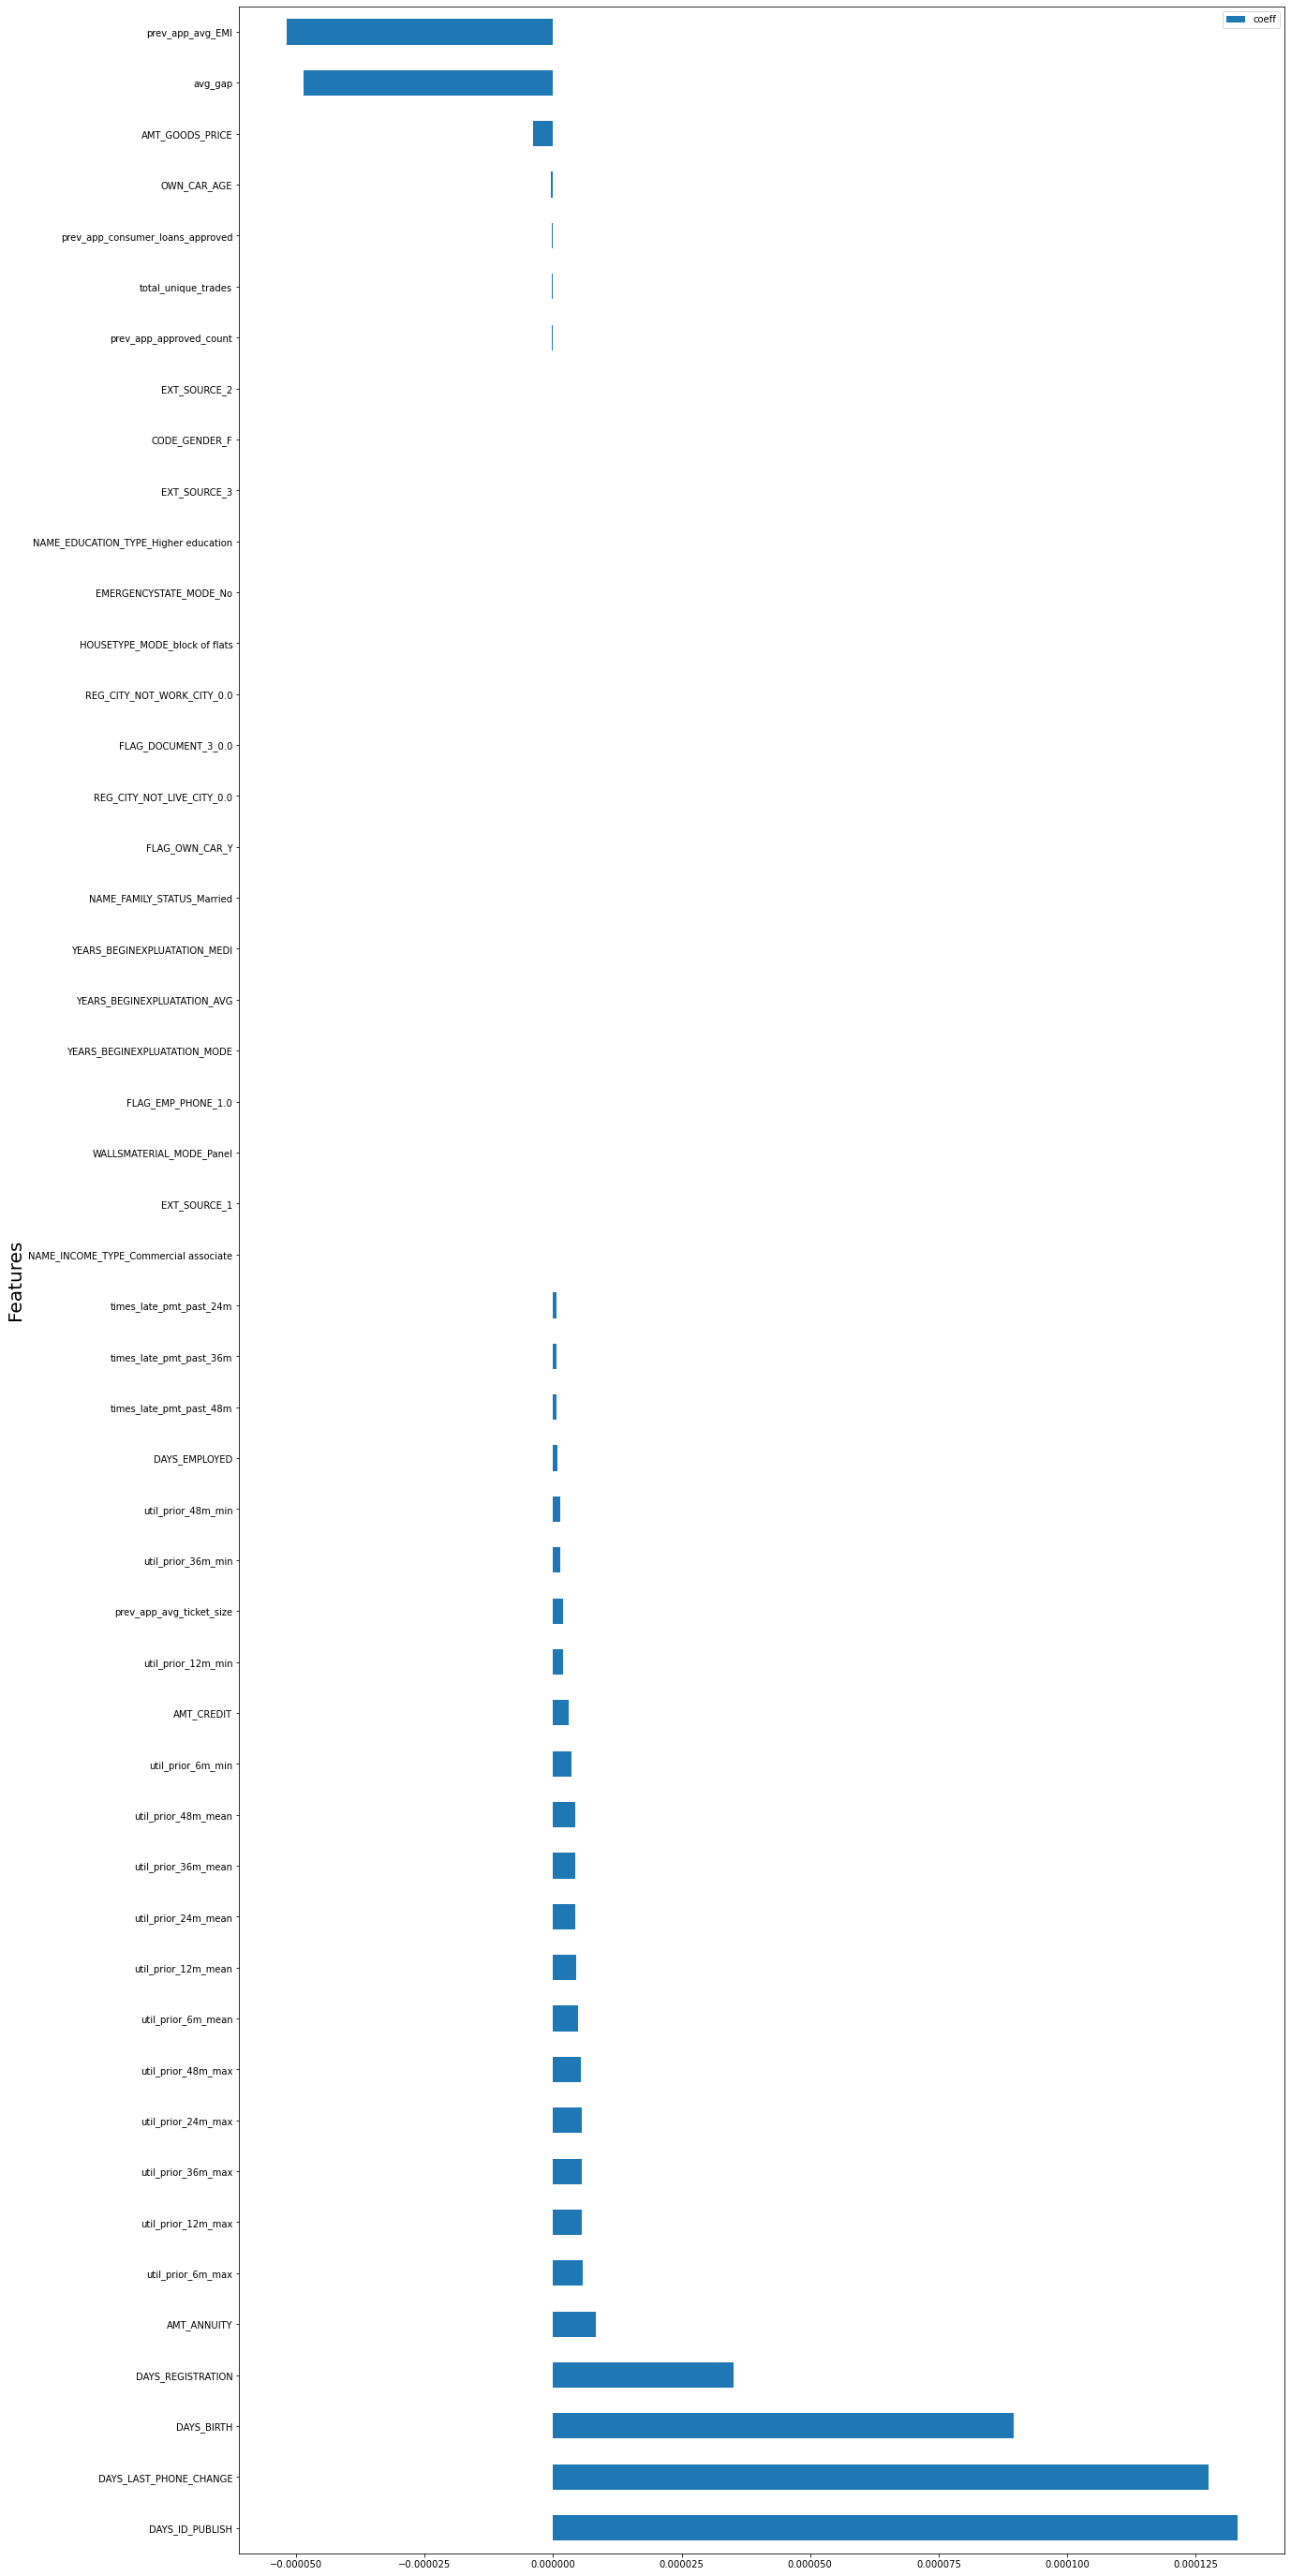

In [186]:
plt.rcParams["figure.figsize"] = (20,50)
feature_importance.plot.barh(x = 'feature')
plt.ylabel('Features', fontsize = 20)
plt.show()

We do some more feature engineering below to convert columns which are measured in Days to years. In addition we normalize certain features like credit amount, annuity amount, goods price usinng minmax scaling.

In [47]:
# Some more feature engineering
X_train[['YEARS_BIRTH','YEARS_REGISTRATION','YEARS_LAST_PHONE_CHANGE','YEARS_ID_PUBLISH','YEARS_AVG_GAP']] = X_train[['DAYS_BIRTH','DAYS_REGISTRATION','DAYS_LAST_PHONE_CHANGE','DAYS_ID_PUBLISH','avg_gap']].apply(lambda x: np.abs(x)/365)
X_train['car_age_own_car'] = X_train.FLAG_OWN_CAR_Y * X_train.OWN_CAR_AGE
X_train.drop(['DAYS_BIRTH','DAYS_REGISTRATION','DAYS_LAST_PHONE_CHANGE','DAYS_ID_PUBLISH','avg_gap'], axis = 'columns', inplace = True)

In [48]:
# Normalizing certain values with min max scaling
from sklearn.preprocessing import MinMaxScaler
min_max_imputer = MinMaxScaler()
X_train[['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']] = min_max_imputer.fit_transform(X_train[['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']])

In [187]:
gc.collect()

111462

### Feature selection using RFECV
Next we will proceed to eliminate the features which are not important and may be adding to noise and deteriorating the model performance. In order to determine the optimum number of features and also the important features we will use Recusrsive feature elimination with cross validation (RFECV). In this technique model is built starting with all features and the weakest features are recursively removed in each step. RFECV uses cross validation to measure model performance on each feature subset.

In [50]:
# Feature selection using RFECV
selector = RFECV(logreg, cv = 5, step = 5,scoring= 'roc_auc',)
selector.fit(X_train, Y_train)

RFECV(cv=5, estimator=LogisticRegression(random_state=1), scoring='roc_auc',
      step=5)

In [92]:
X_train.shape

(307511, 193)

Optimal number of features selected by RFECV:  88


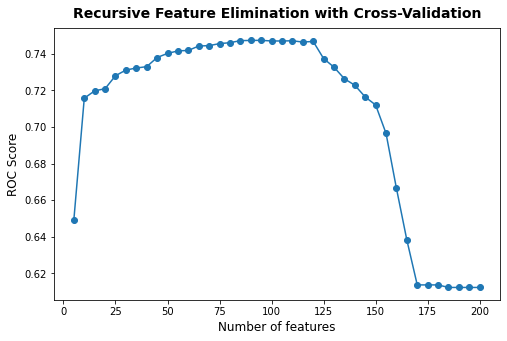

In [100]:
print('Optimal number of features selected by RFECV: ', selector.n_features_)
plt.figure(figsize=(8,5))
plt.plot(pd.Series(range(1, len(selector.grid_scores_) + 1)) *  5, selector.grid_scores_, marker = 'o')
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=14, fontweight='bold', pad = 10)
plt.xlabel('Number of features', fontsize=12)
plt.ylabel('ROC Score', fontsize=12)
plt.show()

As we can see above best model peformance is obtained at 88 features. The list of these 88 features is shown below.

In [52]:
selected_features = X_train.columns[selector.support_]
selected_features

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'BASEMENTAREA_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
       'NONLIVINGAREA_AVG', 'BASEMENTAREA_MODE', 'ENTRANCES_MODE',
       'FLOORSMAX_MODE', 'NONLIVINGAREA_MODE', 'BASEMENTAREA_MEDI',
       'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'NONLIVINGAREA_MEDI',
       'TOTALAREA_MODE', 'total_unique_trades', 'prev_app_approved_count',
       'prev_app_Refused_count', 'prev_app_consumer_loans_approved',
       'times_late_pmt_past_6m', 'times_late_pmt_past_24m',
       'OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Cleaning staff',
       'OCCUPATION_TYPE_Cooking staff', 'OCCUPATION_TYPE_Core staff',
       'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_High skill tech staff',
       'OCCUPATION_TYPE_IT staff', 'OCCUPATION_TYPE_Low-skill Laborers',
       'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Medicine staff',
       'OC

In [54]:
roc_scores = cross_val_score(logreg, X_train[selected_features], Y_train, cv = 10, scoring='roc_auc')

In [55]:
roc_scores

array([0.74931661, 0.74724427, 0.74703517, 0.74896885, 0.74198067,
       0.74113056, 0.74370105, 0.75663823, 0.75355978, 0.75003557])

### Fitting model using optimal features
Fitting the model on selected features through RFECV gives us an **ROC score of 0.7486** which is a significant jump from the baseline model performance (ROC 0.63). This model gives an **ROC of 0.73994 on test data** which indicates that our model is not overfitting.
Thus by doing some feature engineering and eliminating unecessary features we have improved the model performance by approx. 18%

In [56]:
# Fitting the model on selected features
logreg.fit(X_train[selected_features], Y_train)
pred_probs_train = logreg.predict_proba(X_train[selected_features])[:,1]
print("AUC on train set after feature selection and feature engineering: ", roc_auc_score(Y_train, pred_probs_train))
gc.collect()

AUC on train set after feature selection and feature engineering:  0.7486023850375223


1625

Text(0, 0.5, 'Features')

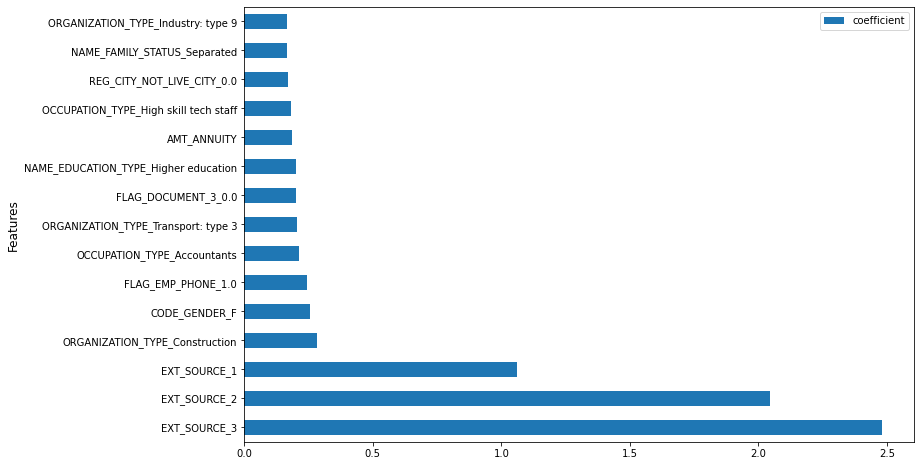

In [157]:
# Feature importance - Top 15 features
feature_dataframe = pd.DataFrame({'features':selected_features, 'coefficient': np.abs(selector.estimator.coef_[0])})
feature_dataframe.sort_values('coefficient',ignore_index = True, ascending = False, inplace = True)
feature_dataframe.iloc[0:15,:].plot.barh(x = 'features', figsize = (12,8))
plt.ylabel('Features', fontsize = 12)

In [159]:
# #Replicate feature engineering on test data and create new submission file
X_test[['YEARS_BIRTH','YEARS_REGISTRATION','YEARS_LAST_PHONE_CHANGE','YEARS_ID_PUBLISH','YEARS_AVG_GAP']] = X_test[['DAYS_BIRTH','DAYS_REGISTRATION','DAYS_LAST_PHONE_CHANGE','DAYS_ID_PUBLISH','avg_gap']].apply(lambda x: np.abs(x)/365)
X_test['car_age_own_car'] = X_test.FLAG_OWN_CAR_Y * X_test.OWN_CAR_AGE
X_test.drop(['DAYS_BIRTH','DAYS_REGISTRATION','DAYS_LAST_PHONE_CHANGE','DAYS_ID_PUBLISH','avg_gap'], axis = 'columns', inplace = True)

# Normalizing certain values with min max scaling
X_test[['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']] = min_max_imputer.transform(X_test[['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']])

In [58]:
pred_probab_test = logreg.predict_proba(X_test[selected_features])[:,1]
submission_df_2 = pd.DataFrame({'SK_ID_CURR': application_test_mapped.SK_ID_CURR, 'TARGET': pred_probab_test})
submission_df_2.to_csv('submission_df_2.csv', index = False)

In [60]:
submission_df_2

,SK_ID_CURR,TARGET
0,100001,0.049109
1,100005,0.231673
2,100013,0.042347
3,100028,0.052248
4,100038,0.129517
...,...,...
48739,456221,0.042999
48740,456222,0.050187
48741,456223,0.037296
48742,456224,0.059044


In [189]:
import joblib
joblib_file = "logreg_model.pkl"  
joblib.dump(logreg, joblib_file)

['logreg_model.pkl']